In [386]:
cd ~/Desktop/ML_project2

/Users/BotezatuCristian/Desktop/ML_project2


# Decision trees (predict the weekday)

In [387]:
# exercise 6.1.2
from sklearn import preprocessing
from sklearn import utils
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, show, boxplot
from scipy.io import loadmat
from sklearn import model_selection, tree
import numpy as np

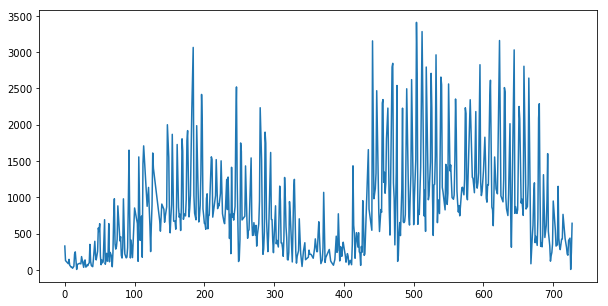

In [388]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import pandas as pd
import numpy as np
df = pd.read_excel('DataSet.xlsx')

df = df[(df.temp<=1) & (df.temp>0) & (df.atemp<=1) & (df.atemp>=0) & (df.hum<=1) & (df.hum>=0) & (df.windspeed <=1) ]
#df['new'] = np.log(((df['new'] - df['new'].mean()) / df['new'].std()).abs()).abs()
plt.plot(df['new'])

In [389]:
#1 out of K encoding for the categorical variables
sub_df = df[[ 'season', 'mnth', 'holiday', 'workingday', 'weekday', 'weathersit']]
cols = [ 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

#No need for 1-out-of-K coding as we are using the data for classification reasons
for each in cols:
    dummies = pd.get_dummies(sub_df[each], prefix=each)
    sub_df = sub_df.drop(each, axis = 1)
    sub_df = pd.concat([ dummies, sub_df], axis=1)
    
sub_df = pd.concat([ df[['hum']], sub_df], axis=1)
sub_df = pd.concat([ df[['temp']], sub_df], axis=1)
sub_df = pd.concat([ df[['atemp']], sub_df], axis=1)
sub_df = pd.concat([ df[['windspeed']], sub_df], axis=1)

# DecisionTreeClassifier for the month

In [390]:
#Standardize the 1 out of K encoded variables
pd.options.mode.chained_assignment = None
df1 = sub_df[[ 'weathersit_1', 'weathersit_2', 'weathersit_3', 'workingday_0', 'workingday_1', 'windspeed', 'atemp', 'temp', 'hum',
            'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
            'season_1', 'season_2', 'season_3', 'season_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
            'weekday_6', 'holiday_0', 'holiday_1']]
for i in ('weathersit_1', 'weathersit_2', 'weathersit_3'):
    df1[i] = (((df1[i] - df1[i].mean()) / df1[i].std()).abs())/math.sqrt(3)
for i in ('workingday_0', 'workingday_1'):
    df1[i] = (((df1[i] - df1[i].mean()) / df1[i].std()).abs())/math.sqrt(2)
for i in ('weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'):
    df1[i] = (((df1[i] - df1[i].mean()) / df1[i].std()).abs())/math.sqrt(7)
for i in ('holiday_0', 'holiday_1'):
    df1[i] = (((df1[i] - df1[i].mean()) / df1[i].std()).abs())/math.sqrt(2)
for i in ('mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12'):
    df1[i] = (((df1[i] - df1[i].mean()) / df1[i].std()).abs())/math.sqrt(12)
for i in ('season_1', 'season_2', 'season_3', 'season_4'):
    df1[i] = (((df1[i] - df1[i].mean()) / df1[i].std()).abs())/math.sqrt(4)
sub_df1 = df1[['windspeed', 'atemp', 'temp', 'hum']]

# Decision tree (error vs. max tree depth)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Computing CV fold: 1/30..
Computing CV fold: 2/30..
Computing CV fold: 3/30..
Computing CV fold: 4/30..
Computing CV fold: 5/30..
Computing CV fold: 6/30..
Computing CV fold: 7/30..
Computing CV fold: 8/30..
Computing CV fold: 9/30..
Computing CV fold: 10/30..
Computing CV fold: 11/30..
Computing CV fold: 12/30..
Computing CV fold: 13/30..
Computing CV fold: 14/30..
Computing CV fold: 15/30..
Computing CV fold: 16/30..
Computing CV fold: 17/30..
Computing CV fold: 18/30..
Computing CV fold: 19/30..
Computing CV fold: 20/30..
Computing CV fold: 21/30..
Computing CV fold: 22/30..
Computing CV fold: 23/30..
Computing CV fold: 24/30..
Computing CV fold: 25/30..
Computing CV fold: 26/30..
Computing CV fold: 27/30..
Computing CV fold: 28/30..
Computing CV fold: 29/30..
Computing CV fold: 30/30..


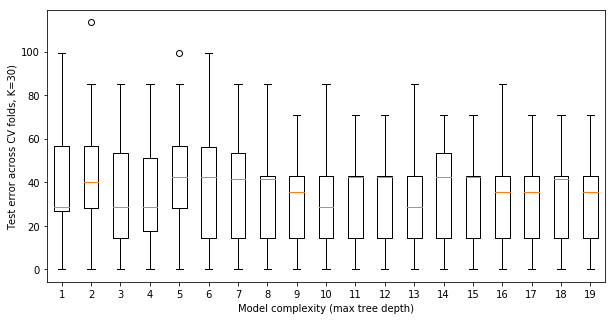

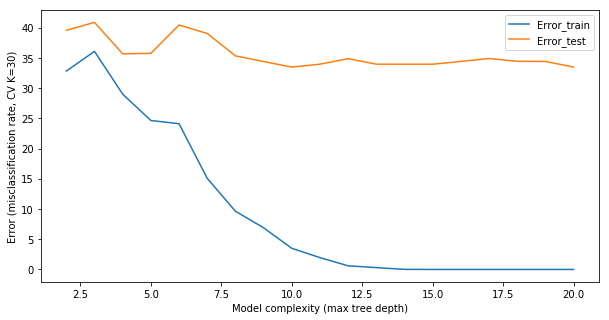

In [391]:
X = sub_df1.as_matrix()
mat_data = X
y = sub_df[['weathersit_2']].as_matrix().ravel()
attributeNames = [name for name in list(sub_df)]
N, M = X.shape
C = 2
# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 21, 1)

# K-fold crossvalidation
K = 30
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variable
Error_train = np.empty((len(tc),K))
Error_test = np.empty((len(tc),K))
k=0
for train_index, test_index in CV.split(X):
    print('Computing CV fold: {0}/{1}..'.format(k+1,K))

    # extract training and test set for current CV fold
    X_train, y_train = X[train_index,:], y[train_index]
    X_test, y_test = X[test_index,:], y[test_index]

    for i, t in enumerate(tc):
        # Fit decision tree classifier, Gini split criterion, different pruning levels
        dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=t)
#         lab_enc = preprocessing.LabelEncoder()
#         encoded = lab_enc.fit_transform(y_train.ravel())
        dtc = dtc.fit(X_train,y_train.ravel(),sample_weight=None, check_input=True, X_idx_sorted=None)
        
        # Evaluate misclassification rate over train/test data (in this CV fold)
        y_est_test = dtc.predict(X_test)
        y_est_train = dtc.predict(X_train)
        misclass_rate_test = sum(np.abs(y_est_test - y_test)) / float(len(y_est_test))
        misclass_rate_train = sum(np.abs(y_est_train - y_train)) / float(len(y_est_train))
        Error_test[i,k] = misclass_rate_test
        Error_train[i,k] = misclass_rate_train
    k+=1

    
f = figure()
boxplot(Error_test.T)
xlabel('Model complexity (max tree depth)')
ylabel('Test error across CV folds, K={0})'.format(K))

f = figure()
plot(tc, Error_train.mean(1))
plot(tc, Error_test.mean(1))
xlabel('Model complexity (max tree depth)')
ylabel('Error (misclassification rate, CV K={0})'.format(K))
legend(['Error_train','Error_test'])
    
show()
f.savefig('DTmaxTreeDepthSummer.png')

# Logistic regression vs. Decision tree

CV-fold 1 of 10
CV-fold 2 of 10
CV-fold 3 of 10
CV-fold 4 of 10
CV-fold 5 of 10
CV-fold 6 of 10
CV-fold 7 of 10
CV-fold 8 of 10
CV-fold 9 of 10
CV-fold 10 of 10
Classifiers are not significantly different


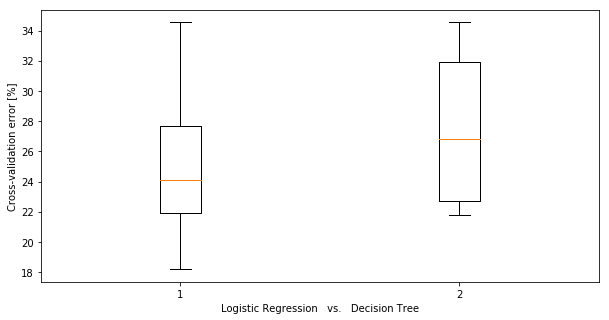

In [392]:
# exercise 6.3.1

from matplotlib.pyplot import figure, boxplot, xlabel, ylabel, show
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection, tree
from scipy import stats

# Load Matlab data file and extract variables of interest
mat_data = X
attributeNames = [name for name in list(sub_df)]
N, M = X.shape
C = 2

# Tree complexity parameter - constraint on maximum depth
tc = np.arange(1, 5, 1)

K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)
#CV = model_selection.StratifiedKFold(n_splits=K)

# Initialize variables
Error_logreg = np.empty((K,1))
Error_dectree = np.empty((K,1))
n_tested=0

k=0
for train_index, test_index in CV.split(X):
    print('CV-fold {0} of {1}'.format(k+1,K))
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]

    # Fit and evaluate Logistic Regression classifier
    model = lm.logistic.LogisticRegression(C=N)
    model = model.fit(X_train, y_train)
    y_logreg = model.predict(X_test)
    Error_logreg[k] = 100*(y_logreg!=y_test).sum().astype(float)/len(y_test)
    
    # Fit and evaluate Decision Tree classifier
    model2 = tree.DecisionTreeClassifier()
    model2 = model2.fit(X_train, y_train)
    y_dectree = model2.predict(X_test)
    Error_dectree[k] = 100*(y_dectree!=y_test).sum().astype(float)/len(y_test)

    k+=1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_logreg-Error_dectree)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Classifiers are not significantly different')        
else:
    print('Classifiers are significantly different.')
    
# Boxplot to compare classifier error distributions
f = figure()
boxplot(np.concatenate((Error_logreg, Error_dectree),axis=1))
xlabel('Logistic Regression   vs.   Decision Tree')
ylabel('Cross-validation error [%]')

show()
f.savefig('LogisticRegAndDT.png')

# Analysis of the test error for KN, Logistic regression and Decision trees

In [393]:
from sklearn.neighbors import KNeighborsClassifier
treeModels = [{'purity':p,'minSplit':m} for p in ['gini','entropy'] for m in range(2,100)]
knnModels = [{'k':k} for k in range(2,40)]

y_cont = y
K_fold = 5
CV_out = model_selection.KFold(K_fold, shuffle=True)

Error_train = np.empty((K_fold, 3))
Error_test = np.empty((K_fold, 3))
k = 0
# You can set dist=1 to obtain manhattan distance (cityblock distance).
dist = 2

for train_index, test_index in CV_out.split(X, y_cont):
    
    internal_cross_validation = 5
    CV_in = model_selection.KFold(internal_cross_validation, shuffle=True)
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y_cont[train_index]
    X_test = X[test_index]
    y_test = y_cont[test_index]
#     --------------------------------------------------------------------------------------
    param_err_dec_tree = []
    for o in treeModels:
        err_inner = 0
        for train_index_inner, test_index_inner in CV_in.split(X_train, y_train):
            X_train_inner = X_train[train_index_inner]
            y_train_inner = y_train[train_index_inner]
            X_test_inner = X[test_index]
            y_test_inner = y_cont[test_index]
            dtc = tree.DecisionTreeClassifier(criterion=o['purity'],min_samples_split = o['minSplit'] )
            dtc = dtc.fit(X_train_inner, y_train_inner)
            y_est_inner = dtc.predict(X_test_inner)
            err_inner += sum(np.abs(y_est_inner != y_test_inner))
        param_err_dec_tree.append(err_inner)
    best_param_dec_tree = treeModels[np.argmin(param_err_dec_tree)]
    best_dtc = tree.DecisionTreeClassifier(criterion=best_param_dec_tree['purity'], min_samples_split= best_param_dec_tree['minSplit'])
    best_dtc = best_dtc.fit(X_train, y_train)
    y_est = best_dtc.predict(X_test)
    err_test =  sum(np.abs(y_est != y_test))
    Error_test[k,0] = float(err_test) / y_test.shape[0]

# ------------------------------------------------------------------------------------------------------
    param_err_knn = []
    for o in knnModels:
        err_inner = 0
        for train_index_inner, test_index_inner in CV_in.split(X_train, y_train):
            X_train_inner = X_train[train_index_inner]
            y_train_inner = y_train[train_index_inner]
            X_test_inner = X[test_index]
            y_test_inner = y_cont[test_index]
            # Fit classifier and classify the test points
            knclassifier = KNeighborsClassifier(n_neighbors=o['k'])
            knclassifier.fit(X_train_inner, y_train_inner)
            y_est_inner = knclassifier.predict(X_test_inner)
            err_inner += sum(np.abs(y_est_inner != y_test_inner))
        param_err_knn.append(err_inner)

    best_param_knn = knnModels[np.argmin(param_err_knn)]
    best_knn = KNeighborsClassifier(n_neighbors=best_param_knn['k'])
    best_knn = best_knn.fit(X_train, y_train)
    y_est = best_knn.predict(X_test)
    err_test = sum(np.abs(y_est != y_test))
    Error_test[k, 1] = float(err_test) / y_test.shape[0]
# ------------------------------------------------------------------------------------------------------
    # LOGISTIC REGRESSION
    model = lm.logistic.LogisticRegression()
    model = model.fit(X_train, y_train)
    y_est = model.predict(X_test)
    err_test = sum(np.abs(y_est != y_test))
    Error_test[k, 2] = float(err_test) / y_test.shape[0]
    k+=1

for i in range(3):
    print(Error_test[:,i].mean())

0.23158341828066603
0.22064220183486238
0.2793408086986069


# Decision tree (classifying based on season - summer)

Selected Parameter : {'purity': 'entropy', 'minSplit': 88}


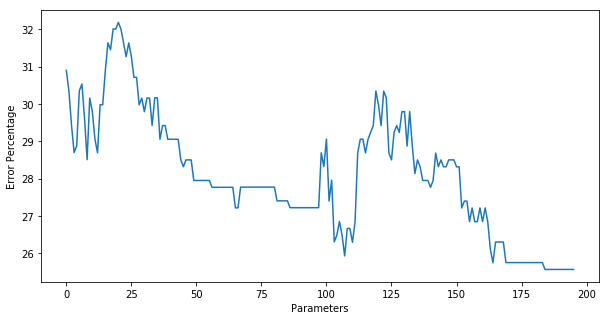

In [440]:
K_fold = 5
CV_out = model_selection.KFold(K_fold, shuffle=True)
treeModels = [{'purity':p,'minSplit':m} for p in ['gini','entropy'] for m in range(2,100)]
param_err_dec_tree = np.zeros(len(treeModels))

for train_index, test_index in CV_out.split(X, y_cont):
    
    internal_cross_validation = 5
    CV_in = model_selection.KFold(internal_cross_validation, shuffle=True)
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y_cont[train_index]
    X_test = X[test_index]
    y_test = y_cont[test_index]
#     --------------------------------------------------------------------------------------

    for index, o in enumerate(treeModels):
        
        dtc = tree.DecisionTreeClassifier(criterion=o['purity'],min_samples_split = o['minSplit'] )
        dtc = dtc.fit(X_train, y_train)
        y_est = dtc.predict(X_test)
        err_inner = 100 *  float(sum(np.abs(y_est != y_test))) / len(y_test)
        param_err_dec_tree[index] += err_inner

        
param_err_dec_tree /= K_fold
best_param_dec_tree = treeModels[np.argmin(param_err_dec_tree)]
f = figure()
plt.plot(param_err_dec_tree)
plt.ylabel('Error Percentage')
plt.xlabel('Parameters')
print('Selected Parameter : ' + str(best_param_dec_tree))

f.savefig('DTErrorAndParWGood.png')

# Decision tree confusion matrix

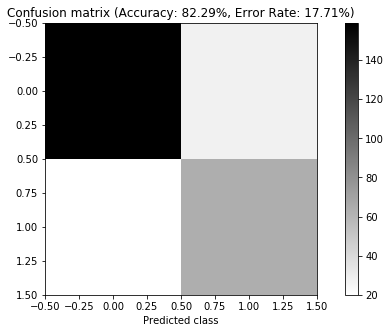

In [435]:
from sklearn.metrics import confusion_matrix
#y_cont = X[:,-5].squeeze()
X_train = X[train_index]
y_train = y_cont[train_index]
X_test = X[test_index]
y_test = y_cont[test_index]
# Fit regression tree classifier, Gini split criterion, no pruning
dtc = tree.DecisionTreeClassifier(criterion=best_param_dec_tree['purity'], min_samples_split=best_param_dec_tree['minSplit'])
dtc = dtc.fit(X,y_cont)
y_est_final = dtc.predict(X_test)

# Compute and plot confusion matrix
cm = confusion_matrix(y_est_final, y_test)
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy

f = figure()
plt.imshow(cm, cmap='binary', interpolation='None')
plt.colorbar()
# plt.xticks(range(C)); yticks(range(C))
plt.xlabel('Predicted class') 
# ylabel('Actual class')
plt.title('Confusion matrix (Accuracy: {0:.2f}%, Error Rate: {1:.2f}%)'.format(accuracy, error_rate))
plt.show()
f.savefig('DTConfMatrixWGood.png')

# KNeighborsClassifier for the summer season

Selected Parameter : {'k': 19, 'dist': 3}


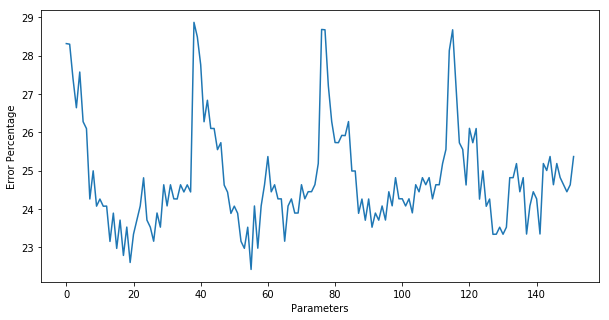

In [396]:
K_fold = 5
CV_out = model_selection.KFold(K_fold, shuffle=True)
knnModels = [{'k':k,'dist':p} for p in range(2,6) for k in range(2,40)]
param_err_k = np.zeros(len(knnModels))

for train_index, test_index in CV_out.split(X, y_cont):
    
    CV_in = model_selection.KFold(internal_cross_validation, shuffle=True)
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y_cont[train_index]
    X_test = X[test_index]
    y_test = y_cont[test_index]
#     --------------------------------------------------------------------------------------

    for index, o in enumerate(knnModels):
        # Fit classifier and classify the test points
        knclassifier = KNeighborsClassifier(n_neighbors=o['k'], p=o['dist'])
        knclassifier.fit(X_train, y_train)
        y_est = knclassifier.predict(X_test)
        err_inner = 100 *  float(sum(np.abs(y_est != y_test))) / len(y_test)
        param_err_k[index] += err_inner

        
param_err_k /= K_fold
best_param_k = knnModels[np.argmin(param_err_k)]

f = figure()
plt.plot(param_err_k)
plt.ylabel('Error Percentage')
plt.xlabel('Parameters')
print('Selected Parameter : ' + str(best_param_k))
f.savefig('KNErrorPar.png')

# KN confusion matrix

In [397]:
# Fit classifier and classify the test points
knclassifier = KNeighborsClassifier(n_neighbors=best_param_k['k'], p=best_param_k['dist'])
knclassifier.fit(X, y_cont)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=3,
           weights='uniform')

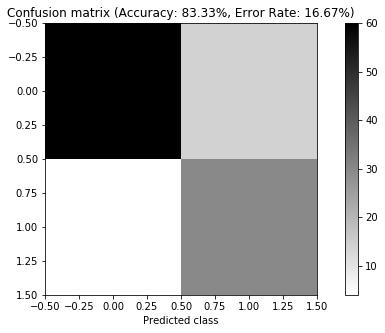

In [398]:
from sklearn.metrics import confusion_matrix
y_est_final = knclassifier.predict(X_test)
X_train = X[train_index,:]
y_train = y_cont[train_index]
X_test = X[test_index,:]
y_test = y_cont[test_index]
# Compute and plot confusion matrix
cm = confusion_matrix(y_est_final, y_test)
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy

f = figure()
plt.imshow(cm, cmap='binary', interpolation='None')
plt.colorbar()
# plt.xticks(range(C)); yticks(range(C))
plt.xlabel('Predicted class') 
# ylabel('Actual class')
plt.title('Confusion matrix (Accuracy: {0:.2f}%, Error Rate: {1:.2f}%)'.format(accuracy, error_rate))

plt.show()
f.savefig('KNConfMatrix.png')

# Logistic regression vs. KNN

CV-fold 1 of 10
CV-fold 2 of 10
CV-fold 3 of 10
CV-fold 4 of 10
CV-fold 5 of 10
CV-fold 6 of 10
CV-fold 7 of 10
CV-fold 8 of 10
CV-fold 9 of 10
CV-fold 10 of 10
Classifiers are not significantly different


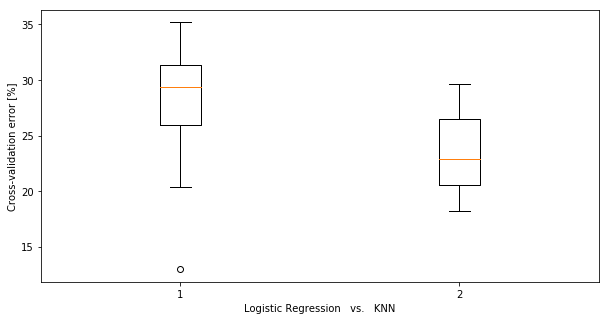

In [399]:
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Error_logreg = np.empty((K,1))
Error_dectree = np.empty((K,1))
n_tested=0

k=0
for train_index, test_index in CV.split(X,y_cont):
    print('CV-fold {0} of {1}'.format(k+1,K))
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y_cont[train_index]
    X_test = X[test_index,:]
    y_test = y_cont[test_index]

    # Fit and evaluate Logistic Regression classifier
    model = lm.logistic.LogisticRegression()
    model = model.fit(X_train, y_train)
    y_logreg = model.predict(X_test)
    Error_logreg[k] = 100*(y_logreg!=y_test).sum().astype(float)/len(y_test)
    
    # Fit and evaluate Decision Tree classifier
    model2 = KNeighborsClassifier(n_neighbors=best_param_k['k'], p=best_param_k['dist'])
    model2 = model2.fit(X_train, y_train)
    y_dectree = model2.predict(X_test)
    Error_dectree[k] = 100*(y_dectree!=y_test).sum().astype(float)/len(y_test)

    k+=1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_logreg-Error_dectree)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Classifiers are not significantly different')        
else:
    print('Classifiers are significantly different.')
    
# Boxplot to compare classifier error distributions
f = figure()
plt.boxplot(np.concatenate((Error_logreg, Error_dectree),axis=1))
plt.xlabel('Logistic Regression   vs.   KNN')
plt.ylabel('Cross-validation error [%]')

plt.show()
f.savefig('LogisticAndKNNWeatherGood.png')

# Logistic regression confusion matrix

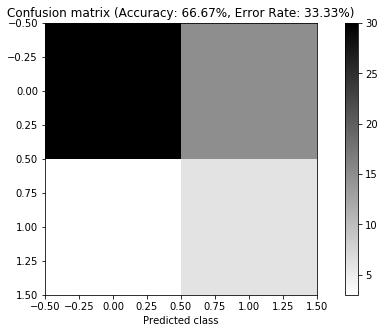

In [400]:
model = lm.logistic.LogisticRegression()
model = model.fit(X,y_cont)
y_est_final = model.predict(X_test)
X_train = X[train_index,:]
y_train = y_cont[train_index]
X_test = X[test_index,:]
y_test = y_cont[test_index]
# Compute and plot confusion matrix
cm = confusion_matrix(y_est_final, y_test)
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy

f = figure()
plt.imshow(cm, cmap='binary', interpolation='None')
plt.colorbar()
# plt.xticks(range(C)); yticks(range(C))
plt.xlabel('Predicted class') 
# ylabel('Actual class')
plt.title('Confusion matrix (Accuracy: {0:.2f}%, Error Rate: {1:.2f}%)'.format(accuracy, error_rate))
plt.show()
f.savefig('LogisticConfMatrix.png')

# Naive Bayes

In [401]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
import numpy as np

# Load list of names from files
X = sub_df1.as_matrix()
mat_data = X
y = sub_df[['season_2']].as_matrix().ravel()

# Naive Bayes classifier parameters
alpha = 1.0         # additive parameter (e.g. Laplace correction)
est_prior = True   # uniform prior (change to True to estimate prior from data)

# K-fold crossvalidation
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

errors = np.zeros(K)
k=0
for train_index, test_index in CV.split(X):
    print('Crossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    
    nb_classifier = MultinomialNB(alpha=alpha, fit_prior=est_prior)
    nb_classifier.fit(X_train, y_train)
    y_est_prob = nb_classifier.predict_proba(X_test)
    y_est = np.argmax(y_est_prob,1)
    
    errors[k] = np.sum(y_est!=y_test,dtype=float)/y_test.shape[0]
    k+=1
    
# Plot the classification error rate
print('Error rate: {0}%'.format(100*np.mean(errors)))

Crossvalidation fold: 1/10
Crossvalidation fold: 2/10
Crossvalidation fold: 3/10
Crossvalidation fold: 4/10
Crossvalidation fold: 5/10
Crossvalidation fold: 6/10
Crossvalidation fold: 7/10
Crossvalidation fold: 8/10
Crossvalidation fold: 9/10
Crossvalidation fold: 10/10
Error rate: 24.420875420875422%


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# Artificial Neural Network classifier

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.



Crossvalidation fold: 1/10
Training network 1/9...
The goal of learning is reached
Training network 2/9...
The goal of learning is reached
Training network 3/9...
The goal of learning is reached
Training network 4/9...
The goal of learning is reached
Training network 5/9...
The goal of learning is reached
Training network 6/9...
The goal of learning is reached
Training network 7/9...
The goal of learning is reached
Training network 8/9...
The goal of learning is reached
Training network 9/9...
The goal of learning is reached
Best train error: 50.647886404266266...

Crossvalidation fold: 2/10
Training network 1/9...
The goal of learning is reached
Training network 2/9...
The goal of learning is reached
Training network 3/9...
The goal of learning is reached
Training network 4/9...
The goal of learning is reached
Training network 5/9...
The goal of learning is reached
Training network 6/9...
The goal of learning is reached
Training network 7/9...
The goal of learning is reached
Training

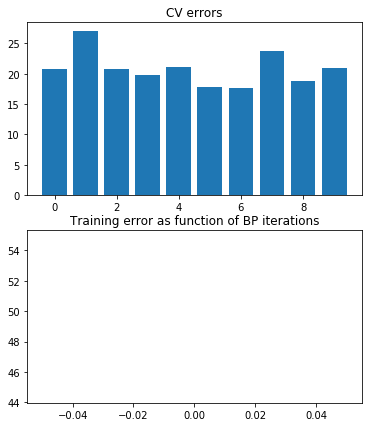

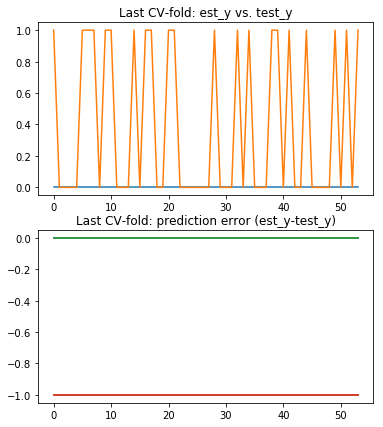

In [404]:
from matplotlib.pyplot import figure, plot, subplot, title, show, bar
import numpy as np
from scipy.io import loadmat
import neurolab as nl
from sklearn import model_selection
from scipy import stats

# Load data from matlab file
mat_data = X
y = sub_df[['weathersit_2']].as_matrix().ravel()
attributeNames = [name for name in list(sub_df)]
N, M = X.shape
C = 2

# Normalize data
X = stats.zscore(X);
                
## Normalize and compute PCA (UNCOMMENT to experiment with PCA preprocessing)
# Y = stats.zscore(X,0);
# U,S,V = np.linalg.svd(Y,full_matrices=False)
# V = V.T
# ##Components to be included as features
# k_pca = 5
# X = X @ V[:,0:k_pca]
# N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = np.arange(1,10,1)     # number of hidden units
n_train = len(n_hidden_units)             # number of networks trained in each k-fold
learning_goal = 100     # stop criterion 1 (train mse to be reached)
max_epochs = 64         # stop criterion 2 (max epochs in training)
show_error_freq = 5     # frequency of training status updates

# K-fold crossvalidation
K = 10                   # only three folds to speed up this example
CV = model_selection.KFold(K,shuffle=True)

# Variable for classification error
errors = np.zeros(K)*np.nan
error_hist = np.zeros((max_epochs,K))*np.nan
bestnet = list()
k=0
for train_index, test_index in CV.split(X,y):
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    
    best_train_error = np.inf
    for i in range(n_train):
        print('Training network {0}/{1}...'.format(i+1,n_train))
        # Create randomly initialized network with 2 layers
        ann = nl.net.newff([[-3, 3]]*M, [n_hidden_units[i], 1], [nl.trans.TanSig(),nl.trans.PureLin()])
        if i==0:
            bestnet.append(ann)
        # train network
        train_error = ann.train(X_train, y_train.reshape(-1,1), goal=learning_goal, epochs=max_epochs, show=show_error_freq)
        if train_error[-1]<best_train_error:
            bestnet[k]=ann
            best_train_error = train_error[-1]
            error_hist[range(len(train_error)),k] = train_error

    print('Best train error: {0}...'.format(best_train_error))
    y_est = bestnet[k].sim(X_test)
    y_est = (y_est>.5).astype(int)
    errors[k] = (y_est!=y_test).sum().astype(float)/y_test.shape[0]
    k+=1
    

# Print the average classification error rate
print('Error rate: {0}%'.format(np.mean(errors)))


f = figure(figsize=(6,7));
subplot(2,1,1); bar(range(0,K),errors); title('CV errors');
subplot(2,1,2); plot(error_hist); title('Training error as function of BP iterations');
figure(figsize=(6,7));
subplot(2,1,1); plot(y_est); plot(y_test); title('Last CV-fold: est_y vs. test_y'); 
subplot(2,1,2); plot((y_est-y_test)); title('Last CV-fold: prediction error (est_y-test_y)'); 

show()
f.savefig('ANNClass.png')

In [413]:
cd ~/Desktop/ML_project2/Tools

/Users/BotezatuCristian/Desktop/ML_project2/Tools


[  0   7   8  10  17  19  21  22  28  29  30  32  35  36  38  39  40  41
  42  44  49  50  52  54  55  56  60  61  63  67  70  73  76  78  82  85
  86  87  88  90  92  96  97  98  99 103 105 107 111 112 113 114 118 119
 120 125 126 128 129 130 135 137 140 144 145 147 148 150 154 155 157 160
 161 164 168 169 172 173 178 183 184 186 187 194 199 200 202 206 209 210
 212 213 214 215 216 218 219 220 221 223 224 226 227 228 229 230 232 237
 238 243 244 245 246 251 252 254 256 257 259 261 262 266 268 269 270 271
 275 276 277 279 281 285 288 289 290 291 292 293 295 296 297 298 300 302
 304 305 307 310 311 312 313 314 315 318 321 322 325 328 330 332 334 337
 340 342 345 347 348 350 354 355 356 358 361 362 364 365 366 369 370 375
 376 377 378 379 383 384 385 386 388 391 394 395 396 401 402 403 405 407
 409 412 414 415 419 425 427 429 430 431 432 434 435 437 439 441 442 445
 446 447 450 451 452 453 454 459 460 461 462 463 466 467 469 472 473 474
 478 479 480 482 485 486 492 494 495 496 497 499 50

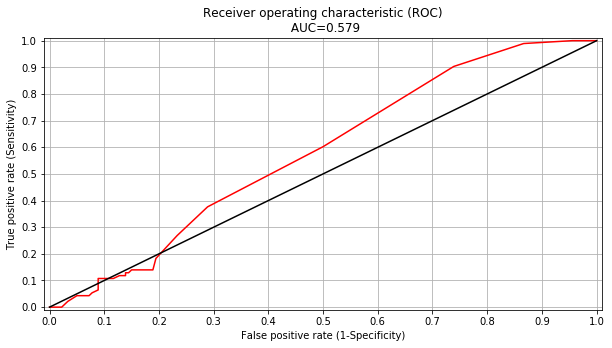

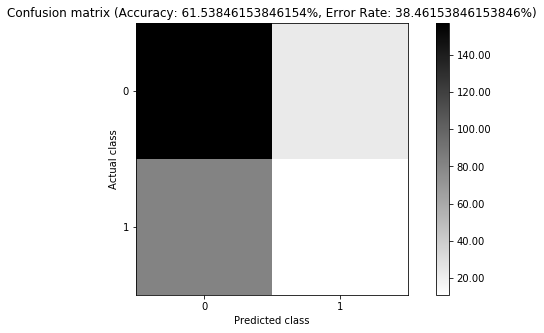

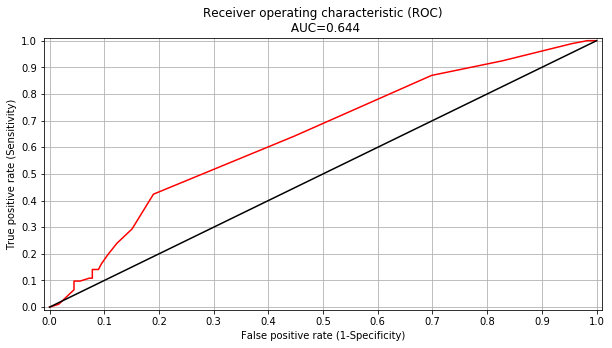

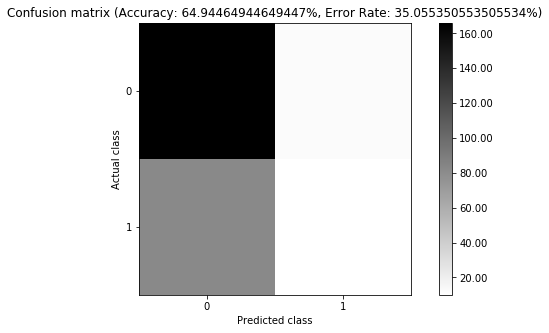

In [418]:
from matplotlib.pyplot import figure, show
#import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from toolbox_02450 import rocplot, confmatplot

N, M = X.shape
C = 2

# K-fold crossvalidation with stratified folds
K = 2
CV = StratifiedKFold(K, shuffle=True)
knnModels = [{'k':k} for k in range(2,40)]

k=0
for train_index, test_index in CV.split(X,y):
    print(train_index)
    # extract training and test set for current CV fold
    X_train, y_train = X[train_index,:], y[train_index]
    X_test, y_test = X[test_index,:], y[test_index]

    #logit_classifier = LogisticRegression()
    #logit_classifier.fit(X_train, y_train)
    knclassifier = KNeighborsClassifier(n_neighbors=o['k'])
    knclassifier.fit(X_train_inner, y_train_inner)

    y_test_est = knclassifier.predict(X_test).T
    p = knclassifier.predict_proba(X_test)[:,1].T

    f1 = figure(k)
    rocplot(p, y_test)
    f1.savefig('KNNConfBase.png')

    f2 = figure(k+1)
    confmatplot(y_test,y_test_est)
    f1.savefig('KNNBase.png')
    
    k+=2
    
show()    

[  6   7   9  12  19  26  27  28  30  31  33  34  35  36  37  38  39  40
  42  43  44  49  51  53  55  58  59  60  61  64  65  67  70  71  75  76
  77  80  81  82  85  88  90  91  92  94  95  96  97  98 103 104 107 108
 109 111 112 116 117 121 123 124 127 131 132 133 135 137 139 141 143 148
 149 150 151 153 155 158 159 160 162 163 165 166 167 168 170 173 174 175
 176 177 179 180 182 183 186 188 193 194 196 198 199 201 204 205 208 209
 211 217 218 219 221 223 224 230 234 235 239 240 242 246 249 251 255 256
 257 259 260 263 265 266 267 271 272 273 275 277 278 283 286 289 293 294
 296 298 301 302 304 305 309 310 312 313 314 316 320 323 325 327 328 329
 330 331 333 334 338 339 340 344 346 348 349 351 352 355 359 363 364 367
 369 371 372 373 375 376 377 379 381 382 383 385 392 394 395 397 398 399
 405 406 407 408 409 418 419 420 421 424 426 428 429 431 432 433 435 436
 437 439 440 441 444 445 446 448 451 452 453 454 455 459 460 462 464 466
 468 469 470 473 477 478 480 487 489 490 491 492 49

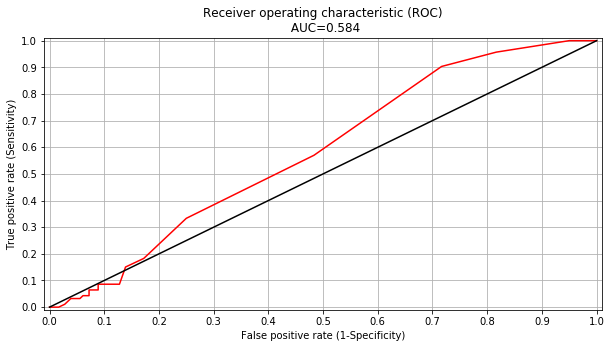

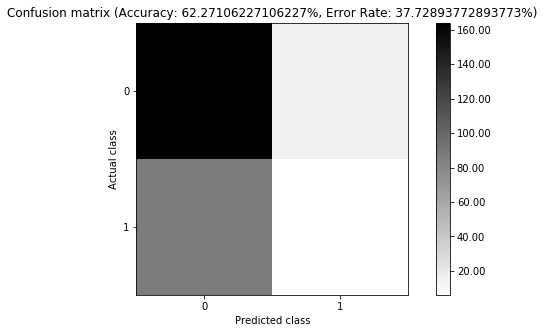

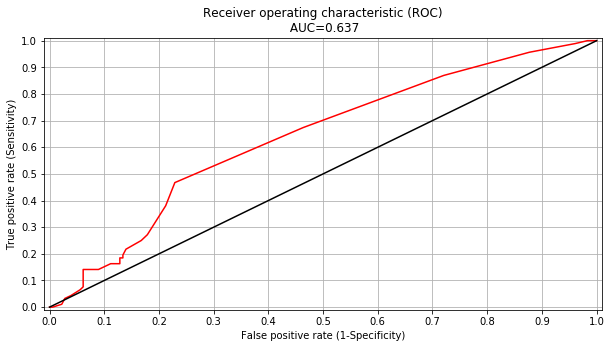

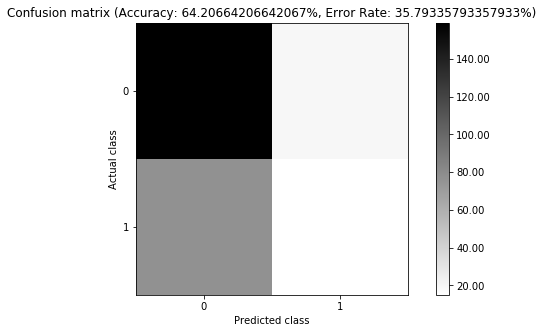

In [434]:
from sklearn.neighbors import KNeighborsClassifier
N, M = X.shape
C = 2

# K-fold crossvalidation with stratified folds
K = 2
CV = StratifiedKFold(K, shuffle=True)
#knnModels = [{'k':k} for k in range(2,40)]
treeModels = [{'purity':p,'minSplit':m} for p in ['gini','entropy'] for m in range(2,100)]

k=0
for train_index, test_index in CV.split(X,y):
    print(train_index)
    # extract training and test set for current CV fold
    X_train, y_train = X[train_index,:], y[train_index]
    X_test, y_test = X[test_index,:], y[test_index]

    #logit_classifier = LogisticRegression()
    #logit_classifier.fit(X_train, y_train)
    #knclassifier = KNeighborsClassifier(n_neighbors=o['k'])
    #knclassifier.fit(X_train_inner, y_train_inner)
    dtc = tree.DecisionTreeClassifier(criterion='gini',min_samples_split = 63)
    dtc.fit(X_train_inner, y_train_inner)

    y_test_est = knclassifier.predict(X_test).T
    p = knclassifier.predict_proba(X_test)[:,1].T

    f1 = figure(k)
    rocplot(p, y_test)
    f1.savefig('DTConfBase.png')

    f2 = figure(k+1)
    confmatplot(y_test,y_test_est)
    f1.savefig('DTBase.png')
    
    k+=2
    
show()    